<b><font size="+4">Linear regression NN in 5 minutes </font></b>

original: [@DataSecrets](https://t.me/+HvSU9GXzgqRmNWY6) </b>

A tutorial for building a simplest linreg network, rewritten for Pytorch instead of TF.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


Generating dataset: points in 2-dim space. 

The task is to predict Y coordinate from X coordinate.

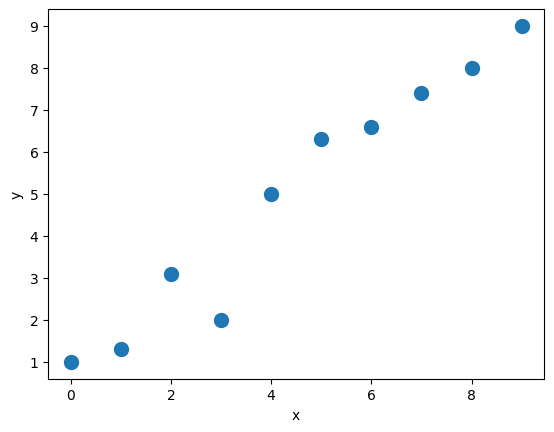

In [2]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Normalizing inputs, because we are making a linear model.

In [3]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)


Now we make a Dataset object, passing inputs and true values at the same time.

In [4]:
from torch.utils.data import TensorDataset

ds_train_orig = TensorDataset(
    torch.tensor(X_train_norm, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)


Next is model architecture. It is very simple: one layer with one node, a linear expression with weight W and bias B.

In [5]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(0.0))
        self.b = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        return self.w * x + self.b


model = MyModel()


Now we need to design training process. First we need a loss function. For that we use a very simple MSE loss function. 

In [6]:
def loss_fn(y_true, y_pred):
    return torch.mean(torch.square(y_true - y_pred))


## тестируем:
yt = torch.tensor([1.0])
yp = torch.tensor([1.5])

loss_fn(yt, yp)


tensor(0.2500)

The training process is as follows: we calculate loss between predicted and true values, then perform a backpropagation pass, calculating the vector gradients. Lastly we update model parameters, substracting from them their gradients, multiplied by learning rate.

In [7]:
def train(model, inputs, outputs, learning_rate):
    current_loss = loss_fn(model(inputs), outputs)
    current_loss.backward()
    model.w = nn.Parameter(model.w.sub(learning_rate * model.w.grad))
    model.b = nn.Parameter(model.b.sub(learning_rate * model.b.grad))
    return current_loss.item()


This process is repeated several times. To automate it we create a DataLoader that shuffles data and feeds it by batches. 
We repeate the training process for several epochs, recording the parameter changes and current loss value.

In [8]:
from torch.utils.data import DataLoader
torch.manual_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

train_loader = DataLoader(ds_train_orig, shuffle=True, batch_size=batch_size)

Ws, bs = [], []
model = MyModel()

step = 0
for i in range(num_epochs):
    for j, batch in enumerate(train_loader):
        step += 1
        if step >= steps_per_epoch * num_epochs:
            break
        Ws.append(model.w.detach().item())
        bs.append(model.b.detach().item())

        bx, by = batch

        loss_val = train(model, bx, by, learning_rate=learning_rate)
        if step % log_steps==0:
            print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
                int(i), step, loss_val))


Epoch    9 Step 100 Loss 54.4337
Epoch   19 Step 200 Loss 0.5857
Epoch   29 Step 300 Loss 13.8735
Epoch   39 Step 400 Loss 15.5821
Epoch   49 Step 500 Loss 0.0630
Epoch   59 Step 600 Loss 4.5781
Epoch   69 Step 700 Loss 1.2841
Epoch   79 Step 800 Loss 2.7344
Epoch   89 Step 900 Loss 1.2063
Epoch   99 Step 1000 Loss 0.7078
Epoch  109 Step 1100 Loss 0.1252
Epoch  119 Step 1200 Loss 0.6311
Epoch  129 Step 1300 Loss 0.0621
Epoch  139 Step 1400 Loss 0.4178
Epoch  149 Step 1500 Loss 0.0200
Epoch  159 Step 1600 Loss 0.0266
Epoch  169 Step 1700 Loss 1.0843
Epoch  179 Step 1800 Loss 1.0168
Epoch  189 Step 1900 Loss 0.1131


After training is complete we can look at the predicted values, and see how the parameters were being optimized at every step.

Final Parameters: 2.6560683 4.8827004


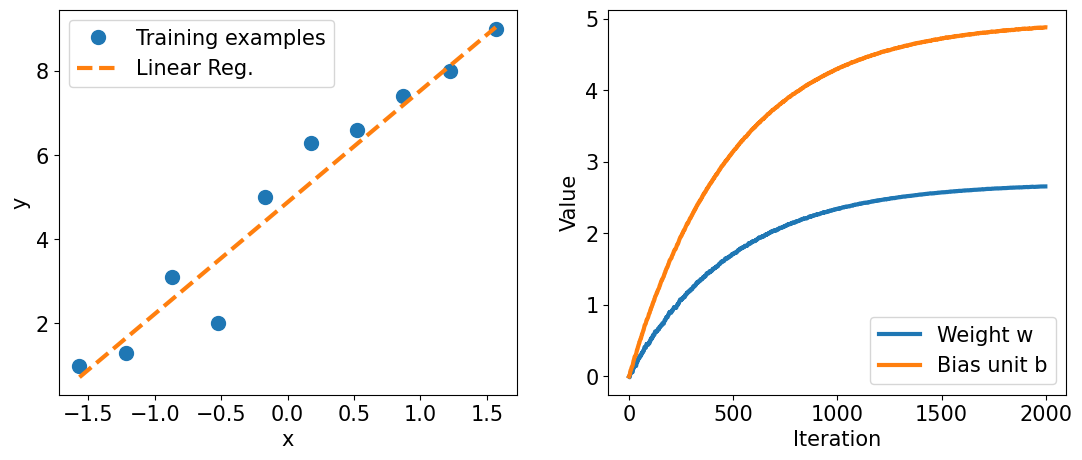

In [9]:
with torch.no_grad():
    print('Final Parameters:', model.w.numpy(), model.b.numpy())

    X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
    X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

    y_pred = model(torch.tensor(X_test_norm, dtype=torch.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('ch13-linreg-1.pdf')

plt.show()


In fact, Pytorch already has built-in methods for everything we need to train our model, e.g. loss functions and optimizers. 
We can do the same using these capabilities, and the result we get will be very similar.

In [10]:
from torch.optim import SGD
from torch.nn.functional import mse_loss
torch.manual_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

Ws, bs = [], []

train_loader = DataLoader(ds_train_orig, shuffle=True)
model2 = MyModel()
optim = SGD(params=model2.parameters(), lr=learning_rate)


def train_loop(dataloader, model, loss_fn, optim):
    step = 0
    for i in range(num_epochs):
        for batch in dataloader:
            step += 1
            if step >= steps_per_epoch * num_epochs:
                break
            Ws.append(model.w.detach().item())
            bs.append(model.b.detach().item())


            inputs, preds = batch
            outputs = model(inputs)
            loss_val = loss_fn(preds.unsqueeze(dim=-1), outputs)
            loss_val.backward()
            optim.step()
            optim.zero_grad()

            if step % log_steps==0:
                print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
                    int(i), step, loss_val))

train_loop(train_loader, model2, mse_loss, optim)


Epoch    9 Step 100 Loss 54.4337
Epoch   19 Step 200 Loss 0.5857
Epoch   29 Step 300 Loss 13.8735
Epoch   39 Step 400 Loss 15.5821
Epoch   49 Step 500 Loss 0.0630
Epoch   59 Step 600 Loss 4.5781
Epoch   69 Step 700 Loss 1.2841
Epoch   79 Step 800 Loss 2.7344
Epoch   89 Step 900 Loss 1.2063
Epoch   99 Step 1000 Loss 0.7078
Epoch  109 Step 1100 Loss 0.1252
Epoch  119 Step 1200 Loss 0.6311
Epoch  129 Step 1300 Loss 0.0621
Epoch  139 Step 1400 Loss 0.4178
Epoch  149 Step 1500 Loss 0.0200
Epoch  159 Step 1600 Loss 0.0266
Epoch  169 Step 1700 Loss 1.0843
Epoch  179 Step 1800 Loss 1.0168
Epoch  189 Step 1900 Loss 0.1131


Let's plot the alternative:

2.6560683 4.8827004


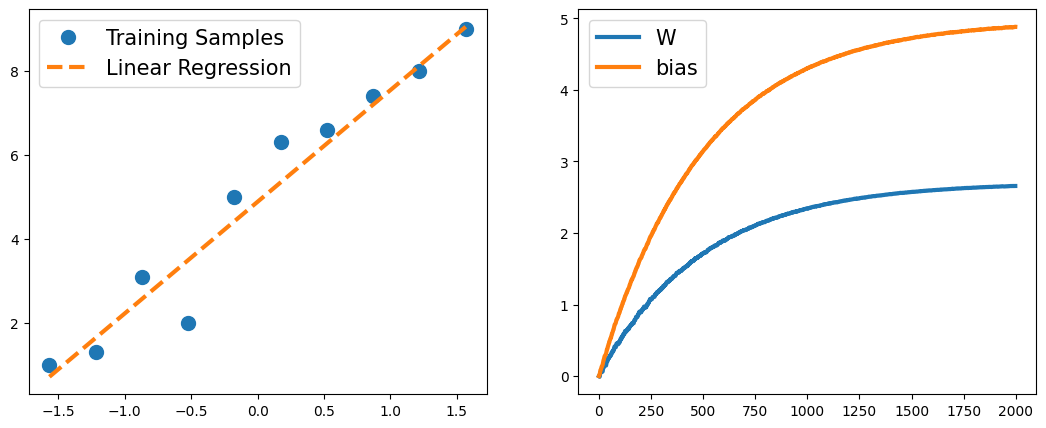

In [11]:
with torch.no_grad():
    print(model2.w.numpy(), model2.b.numpy())

    X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
    X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

    y_pred = model2(torch.tensor(X_test_norm, dtype=torch.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()
